## Importing libraries

In [1]:
import torch
import torchvision
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor,ToPILImage
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt
import numpy as np
import torchvision.datasets as datasets

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-v3784rnk because the default path (/run/user/141228/cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Data and device loading

In [2]:
torch.backends.cudnn.benchmark = True
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [3]:
stats= ((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010)) #mean and std
train_tfm= tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), # transormation of data together
                       tt.RandomHorizontalFlip(),
                       tt.ToTensor()])
valid_tfm = tt.Compose([tt.ToTensor()])

In [4]:
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=train_tfm,
)

Files already downloaded and verified


In [5]:
# Download test data from open datasets.
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=valid_tfm,
)

Files already downloaded and verified


In [6]:
valid_ds = test_data
train_ds = training_data
train_ds

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [7]:
batch_size_res9=400
batch_size_res20=400

In [8]:
# Dataloader to load data in batches(mini batch)
train_dl_res9= DataLoader(train_ds,batch_size_res9,shuffle=True, num_workers=3, pin_memory=True) 
valid_dl_res9= DataLoader(valid_ds, batch_size_res9, num_workers=3,pin_memory=True) 

train_dl_res20= DataLoader(train_ds,batch_size_res20,shuffle=True, num_workers=3, pin_memory=True) 
valid_dl_res20= DataLoader(valid_ds, batch_size_res20, num_workers=3,pin_memory=True)

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
train_dl_res9= DeviceDataLoader(train_dl_res9, device)
valid_dl_res9 = DeviceDataLoader(valid_dl_res9, device)

train_dl_res20= DeviceDataLoader(train_dl_res20, device)
valid_dl_res20 = DeviceDataLoader(valid_dl_res20, device)

## Training loop

In [11]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

## Resnets

In [12]:
def conv_block_res9(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block_res9(in_channels, 64)
        self.conv2 = conv_block_res9(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block_res9(128, 128), conv_block_res9(128, 128))
        
        self.conv3 = conv_block_res9(128, 256, pool=True)
        self.conv4 = conv_block_res9(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block_res9(512, 512), conv_block_res9(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [13]:
def conv_block_res20(in_channels, out_channels, stride=1):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    return nn.Sequential(*layers)

def shortcut(in_channels, out_channels):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=2)

class ResNet20(ImageClassificationBase):
    def __init__(self, in_channels, num_classes, n):
        super().__init__()
        
        self.n = n
        
        # 32x32 map
        self.conv1 = conv_block_res20(in_channels, 16)
        self.reg32 = nn.Sequential(conv_block_res20(16,16), conv_block_res20(16,16))
        
        # 16x16 map
        self.entry16 = nn.Sequential(conv_block_res20(16, 32, stride=2), conv_block_res20(32, 32))
        self.short16 = shortcut(16, 32)
        self.reg16 = nn.Sequential(conv_block_res20(32, 32), conv_block_res20(32, 32))
        
        # 8x8 map
        self.entry8 = nn.Sequential(conv_block_res20(32, 64, stride=2), conv_block_res20(64, 64))
        self.short8 = shortcut(32, 64)
        self.reg8 = nn.Sequential(conv_block_res20(64, 64), conv_block_res20(64, 64))
        
        self.classifier = nn.Sequential(nn.AvgPool2d(kernel_size=8, stride=None, padding=0), 
                                        nn.Linear(64, num_classes),
                                       nn.Softmax())
        # FOR DEBUGGING
        self.avg = nn.AvgPool2d(kernel_size=8, stride=None, padding=0)
        self.flat = nn.Flatten()
        self.fcl = nn.Linear(64, num_classes)
        self.sm = nn.Softmax()
        
    def forward(self, xb):
        out = self.conv1(xb)
        
        for i in range(self.n):
            out = self.reg32(out) + out
            
        out = self.entry16(out) + self.short16(out)
        for i in range(self.n - 1):
            out = self.reg16(out) + out
            
        out = self.entry8(out) + self.short8(out)
        for i in range(self.n - 1):
            out = self.reg8(out) + out

        #out = self.classifier(out)
        out = self.avg(out)
        out = self.flat(out)
        out = self.fcl(out)
        out = self.sm(out)
        
        return out

## Transfer to device

In [14]:
# model_res9 = to_device(ResNet9(3,10), device)
model_res20 = to_device(ResNet20(3,10,3), device)

In [15]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()  # Realsing cuda memory otherwise might get cuda out of memory error
    history = []
    
    #custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train() #Setting training mode
        train_losses = []
        lrs = [] 
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader) 
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [16]:
# # Smoke test: if something's wrong with how we set up our model, we'll see it now
# histories = {"ResNet-9": [evaluate(model_res9, valid_dl_res9)], "ResNet-20": [evaluate(model_res20, valid_dl_res20)]}

# print(histories)

## Training

In [17]:
epochs_res9 = 70
epochs_res20 = 140
histories = {"ResNet-20":[]}
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [18]:
# %%time
# histories["ResNet-9"] += fit_one_cycle(epochs_res9, max_lr, model_res9, train_dl_res9, valid_dl_res9, 
#                              grad_clip=grad_clip, 
#                              weight_decay=weight_decay, 
#                              opt_func=opt_func)

In [19]:
%%time
histories["ResNet-20"] += fit_one_cycle(epochs_res20, max_lr, model_res20, train_dl_res20, valid_dl_res20, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/home/userfs/s/sb2444/.local/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [0], train_loss: 2.2301, val_loss: 2.2020, val_acc: 0.2457
Epoch [1], train_loss: 2.1558, val_loss: 2.1436, val_acc: 0.3246
Epoch [2], train_loss: 2.1155, val_loss: 2.1172, val_acc: 0.3545
Epoch [3], train_loss: 2.0719, val_loss: 2.1052, val_acc: 0.3587
Epoch [4], train_loss: 2.0301, val_loss: 2.1199, val_acc: 0.3350
Epoch [5], train_loss: 2.0018, val_loss: 2.0652, val_acc: 0.3979
Epoch [6], train_loss: 1.9784, val_loss: 2.0723, val_acc: 0.3843
Epoch [7], train_loss: 1.9583, val_loss: 2.0704, val_acc: 0.3848
Epoch [8], train_loss: 1.9392, val_loss: 2.0219, val_acc: 0.4464
Epoch [9], train_loss: 1.9226, val_loss: 2.0255, val_acc: 0.4359
Epoch [10], train_loss: 1.9018, val_loss: 1.9946, val_acc: 0.4697
Epoch [11], train_loss: 1.8846, val_loss: 1.9498, val_acc: 0.5140
Epoch [12], train_loss: 1.8692, val_loss: 1.9859, val_acc: 0.4769
Epoch [13], train_loss: 1.8535, val_loss: 2.0130, val_acc: 0.4472
Epoch [14], train_loss: 1.8416, val_loss: 1.9882, val_acc: 0.4714
Epoch [15], train_lo

## Graphs

In [20]:
def plot_accuracies(histories):
    for resnet in  histories.keys():
        history = histories[resnet]
        accuracies = [x['val_acc'] for x in history]
        plt.figure(figsize=(10,6))
        plt.plot(accuracies, '-x')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.title(f'{resnet} Accuracy vs. No. of epochs');
    
def plot_losses(histories):
    for resnet in  histories.keys():
        history = histories[resnet]
        train_losses = [x.get('train_loss') for x in history]
        val_losses = [x['val_loss'] for x in history]
        plt.figure(figsize=(10,6))
        plt.plot(train_losses, '-bx')
        plt.plot(val_losses, '-rx')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend(['Training', 'Validation'])
        plt.title(f'{resnet} Loss vs. No. of epochs');
    
def plot_lrs(histories):
    for resnet in  histories.keys():
        history = histories[resnet]
        lrs = np.concatenate([x.get('lrs', []) for x in history])
        plt.figure(figsize=(10,6))
        plt.plot(lrs)
        plt.xlabel('Batch no.')
        plt.ylabel('Learning rate')
        plt.title(f'{resnet} Learning Rate vs. Batch no.');

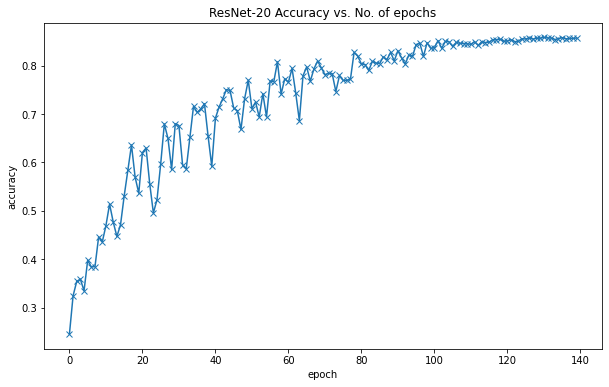

In [21]:
plot_accuracies(histories)

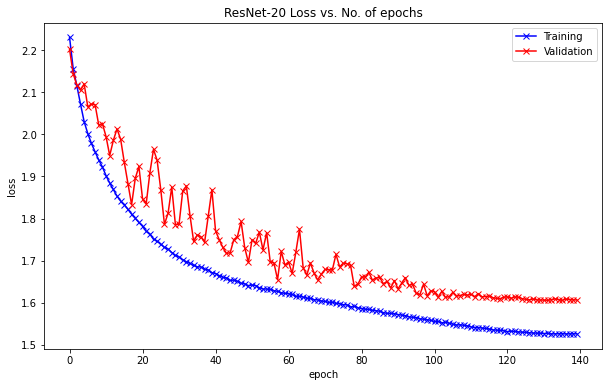

In [22]:
plot_losses(histories)

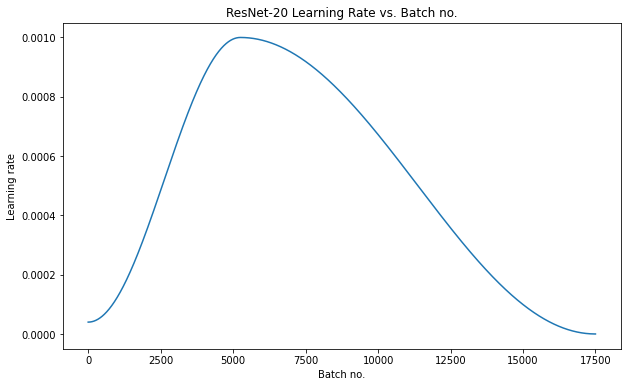

In [23]:
plot_lrs(histories)